<a href="https://colab.research.google.com/github/LeaCarop/Serie_temporal/blob/main/Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRIMERA PARTE**
## Pronóstico de Serie Temporal con redes neuronales. 

#### Basado en el ejercicio disponible en https://www.aprendemachinelearning.com/pronostico-de-series-temporales-con-redes-neuronales-en-python/ En esta página hay muchos más links disponibles para entender todo lo que se hace.

Se trata de un ejercicio sencillo ideal para comenzar a aprender.

* ¿Qué es una serie temporal?: conjunto de muestras tomadas a intervalos de tiempo regulares. 
* Las series temporales (a diferencia de una regresión) es dependiente del tiempo (las observaciones de las regresiones son dependientes).
* Suelen tener algún tipo de estacionalidad o de tendencias al alza o a la baja.
* Las series puden ser de una sola variable o de múltiples. 

In [1]:
# IMPORTAR LIBRERÍAS

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (16, 9) # para personalizar la dimensión de todos los gráficos
plt.style.use('fast') # para crear un estilo personalizado

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.preprocessing import MinMaxScaler

In [2]:
# CARGAR ARCHIVO CSV CON LOS DATOS

url = "https://raw.githubusercontent.com/jbagnato/machine-learning/master/time_series.csv"
df = pd.read_csv(url, parse_dates=[0], header=None, index_col=0, squeeze=True, names=['fecha','unidades'])
df.head()

# parse_dates: Determina si las columnas conteniendo fechas pero estén en otros formatos (texto) deberán ser convertidas a formato de fechas o no
# header (encabezado): es un bloque de comentarios en la parte superior del código, que incluye el nombre del archivo, el autor, la fecha y algunos      
                     # otros detalles del archivo y el contenido de ese archivo
# index_col: el número de columna que contiene los nombre para usar como index
# squeeze: si los datos analizados solo contienen una columna, devuelva una serie.
# names: lista de nombres de columna a utilizar

fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
Name: unidades, dtype: int64

Con `index_col` se ha colocado la columna `fecha` como índice. Esto permitre hacer filtrado por fechas y otras operaciones.

In [3]:
print(df.index.min())
print(df.index.max())

# con estas operaciones sacamos el horizonte temporal (fecha de inicio y final) de la serie temporal analizada

2017-01-02 00:00:00
2018-11-30 00:00:00


In [4]:
# Datos estadísticos

df.describe()

count    604.000000
mean     215.935430
std       75.050304
min       51.000000
25%      171.000000
50%      214.000000
75%      261.250000
max      591.000000
Name: unidades, dtype: float64

In [5]:
# Análisis de los promedios mensuales
## Antes teníamos los datos diarios y ahora se calcula la media mensual

meses = df.resample('M').mean()
meses

fecha
2017-01-31    203.923077
2017-02-28    184.666667
2017-03-31    182.964286
2017-04-30    198.960000
2017-05-31    201.185185
2017-06-30    209.518519
2017-07-31    278.923077
2017-08-31    316.000000
2017-09-30    222.925926
2017-10-31    207.851852
2017-11-30    185.925926
2017-12-31    213.200000
2018-01-31    201.384615
2018-02-28    190.625000
2018-03-31    174.846154
2018-04-30    186.000000
2018-05-31    190.666667
2018-06-30    196.037037
2018-07-31    289.500000
2018-08-31    309.038462
2018-09-30    230.518519
2018-10-31    209.444444
2018-11-30    184.481481
Freq: M, Name: unidades, dtype: float64

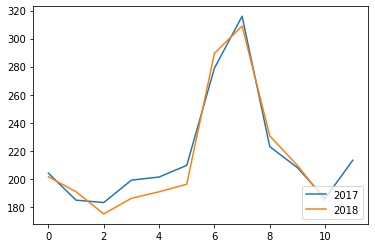

In [6]:
# Representar medias mensuales

plt.plot(meses['2017']. values, label = "2017")
plt.plot(meses['2018']. values, label = "2018")
plt.legend(loc="lower right")

El año 2017 comienza con una disminución en las ventas mensuales y que luego comienza a subir durante el segundo trimestre, coinciendiendo con la época de verano. El año 2018 tiene un comportamiento parecido a 2017, pero se podría resumir a simple vista que salvo algunas fechas puntuales 2017 fue un mejor año.

Dado que en ambos años coincide que las ventas aumentan en el mismo período, veamos la gráfica diaria de ventas en estos meses (junio y julio).

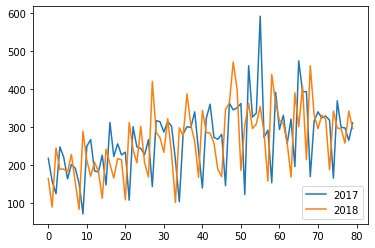

In [7]:
verano2017 = df['2017-06-01':'2017-09-01']
plt.plot(verano2017.values, label = '2017')
verano2018 = df['2018-06-01':'2018-09-01']
plt.plot(verano2018.values, label = '2018')
plt.legend(loc="lower right")

Para hacer un pronóstico a futuro de lo que sucederá el próximo año con las ventas se pueden usar varios métodos: 
* Un modelo muy usado en estadística es el **modelo ARIMA** que se utiliza para hacer pronósticos en series temporales.
* **Redes neuronales** es el método que se utiliza en este ejercicio.

Explicación del modelo ARIMA en https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

## PRONÓSTICO DE VENTAS DIARIAS CON RED NEURONAL

Usaremos una arquitectura sencilla de red neuronal FeedForward (también llamada MLP por sus siglas Perceptón multicapa), con pocas neuronas y como método de activación tangente hiperbólica pues entregaremos valores transformados entre -1 y 1.

Lo que haremos es alterar nuestro flujo de entrada del archivo csv que contiene una columna con las unidades despachadas, y lo convertiremos en varias columnas. ¿Y porqué hacer esto? En realidad lo que haremos es tomar nuestra serie temporal y la convertiremos en un “problema de tipo supervisado“ para poder alimentar nuestra red neuronal y poder entrenarla con **retropropagación**. Para hacerlo, debemos tener unas entradas y unas salidas para entrenar al modelo.

¿Qué es esto de retropropagación? 
Un perceptrón multicapa con retropropagación hace los siguientes pasos: 
* Durante el entrenamiento el algoritmo de retropropagación hace una predicción (paso hacia delante) y mide el error
* Vuelve por cada capa en orden inverso (paso hacia atrás) para medir la contribucuón al error de cada conexión 
* Ajusta los pesos de conexión para reducir el error (paso de descenso de gradiente)

Lo que haremos -en este ejemplo- es tomar los 7 días previos para “obtener” el octavo.
* **Entradas**: serán “7 columnas” que representan las ventas en unidades de los 7 días anteriores.
* **Salida**: El valor del “8vo día”. Es decir, las ventas (en unids) de ese día.

Para hacer esta transformación se usará una función llamada ***series_to_supervised()*** que toma una serie temporal univariante o multivariante y la enmarca como un conjunto de datos de aprendizaje supervisado.

La función toma cuatro argumentos:
* **datos**: Secuencia de observaciones como una lista o matriz NumPy 2D. Obligatorio.
* **n_in**: Número de observaciones de retraso como entrada (X). Los valores pueden estar entre [1..len(data)] Opcional. El valor predeterminado es 1.
* **n_out**: Número de observaciones como producto (y). Los valores pueden estar entre [0..len(data)-1]. Opcional. El valor predeterminado es 1.
* **dropnan**: Booleano si se deben o no soltar filas con valores de NaN. Opcional. El valor predeterminado es True.

La función devuelve un único valor:
* **return**: Pandas DataFrame de series enmarcadas para el aprendizaje supervisado.

Antes de usar la función, utilizamos el MinMaxScaler para transformar el rango de nuestros valores entre -1 y 1.

A continuación vemos cómo queda nuestro set de datos de entrada.

In [8]:
PASOS=7

# convertir series en aprendizaje supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia de pronóstico (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # poner todo junto
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # eliminar filas con valores NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargar datos
values = df.values
# asegúrese de que todos los datos sean flotantes
values = values.astype('float32')
# normalizar variable
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# enmarcar como aprendizaje supervisado
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()



,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


Usaremos como entradas las columnas encabezadas como var1(t-7) a (t-1) y nuestra salida (lo que sería el valor “Y” de la función) será el var1(t) -la última columna-.

Antes de crear la red neuronal, subdividiremos nuestro conjunto de datos en train y en test. ATENCIÓN, algo importante de este procedimiento, a diferencia de en otros problemas en los que podemos “mezclar” los datos de entrada, es que en este caso nos importa mantener el orden en el que alimentaremos la red. Por lo tanto, haremos una subdivisión de los primeros 567 días consecutivos para entrenamiento de la red y los siguientes 30 para su validación.

*Esta proporción de división fue elección de la persona creadora del ejercicio. Puede ser modificada.*

In [9]:
# DIVIDIR DATASET EN TRAIN Y TEST

values = reframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 7) (567,) (30, 1, 7) (30,)


Se ha transformado la entrada en un arreglo con forma (567,1,7) esto significa algo así como “567 entradas con vectores de 1×7”.

La arquitectura de la red neuronal será:
- Entrada 7 inputs
- 1 capa oculta con 7 neuronas (este valor lo escogí yo, pero se puede variar)
- La salida será 1 sola neurona (porque predecimos un solo valor)
- Como función de activación utilizamos tangente hiperbólica puesto que utilizaremos valores entre -1 y 1. Usar tanh permite **acelerar la convergencia**
- Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error (mae)
- Como la predicción será un valor continuo y no discreto, para calcular el Acuracy utilizaremos Mean Squared Error (mse) y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

In [10]:
# ARQUITECTURA DE LA RED NEURONAL

def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [11]:
# ENTRENAMIENTO

EPOCHS=40
 
model = crear_modeloFF()
 
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 7)              56        
                                                                 
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
81/81 [==============================] - 1s 5ms/step - loss: 0.3800 - mse: 0.2216 - val_loss: 0.2870 - val_mse: 0.1235
Epoch 2/40
81/81 [==============================] - 0s 2ms/step - loss: 0.3276 - mse: 0.1595 - val_loss: 0.2546 - val_mse: 0.0975
Epoch 3/40
81/81 [==============================] - 0s 3ms/step 

Vemos en EPOCH 40 una reducción del valor de pérdida tanto del set de entrenamiento como del de validación.

Ahora visualizamos el conjunto de test que eran 30 días.

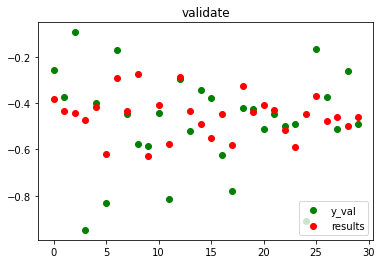

In [14]:
# PREDICCIÓN

results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g', label= 'y_val')
plt.scatter(range(len(results)),results,c='r', label = 'results')
plt.title('validate')
plt.legend(loc="lower right")
plt.show()

En la gráfica vemos que los puntitos verdes intentan aproximarse a los rojos. Cuanto más cerca ó superpuestos mejor. **TIP**: Si aumentamos la cantidad de EPOCHS mejora cada vez más.

Veamos y comparemos también cómo disminuye el LOSS tanto en el conjunto de train como el de Validate, esto es bueno ya que indica que el modelo está aprendiendo. A su vez pareciera no haber overfitting, pues las curvas de train y validate son distintas.

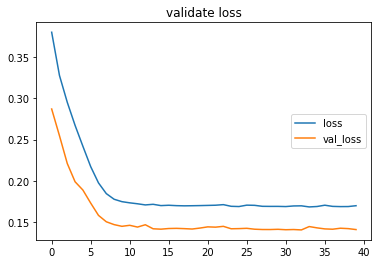

In [15]:
plt.plot(history.history['loss'], label = 'loss')
plt.title('loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('validate loss')
plt.legend(loc="right")
plt.show()

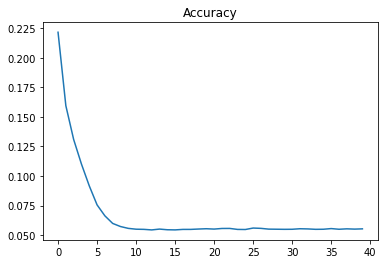

In [16]:
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [17]:
# COMPARAR LOS DATOS REALES Y PREDICHOS

compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,252.000000,218.055283,33.944717
1,220.000000,204.224197,15.775803
2,296.000000,202.019806,93.980194
3,64.999992,193.748627,-128.748627
4,213.000000,208.115845,4.884155


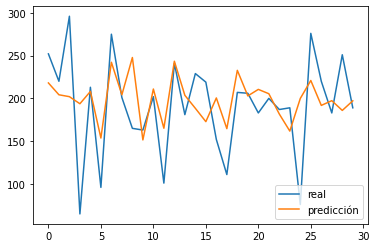

In [18]:
plt.plot(compara2['real']. values, label = "real")
plt.plot(compara2['prediccion']. values, label = "predicción")
plt.legend(loc="lower right")

Comparando los datos reales con los predichos vemos que no hay exactitud, más bien los datos de predicción graficamente parecen una media de los datos reales.

## PRONÓSTICO DE VENTAS FUTURAS

Ahora que tenemos nuestra red y -suponiendo que realizamos los 7 pasos del ML– la damos por buena, probaremos a realizar una nueva predicción, en este caso, usaremos los últimos días de noviembre 2018 para calcular la primer semana de diciembre.

In [19]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

fecha
2018-11-16    152
2018-11-17    111
2018-11-19    207
2018-11-20    206
2018-11-21    183
2018-11-22    200
2018-11-23    187
2018-11-24    189
2018-11-25     76
2018-11-26    276
2018-11-27    220
2018-11-28    183
2018-11-29    251
2018-11-30    189
Name: unidades, dtype: int64

Seguimos con el mismo preprocesado de datos anterior: 
* escalando los valores 
* llamando a la función series_to_supervised pero esta vez sin incluir la columna de salida “Y” pues es la que queremos hallar. Por eso, verán en el código que hacemos drop() de la última columna.

In [20]:
values = ultimosDias.values
values = values.astype('float32')
# normalizo variables
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
8,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
9,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
10,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
11,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
12,0.24,0.11,0.13,-1.00,1.00,0.44,0.07
13,0.11,0.13,-1.00,1.00,0.44,0.07,0.75


De este conjunto “ultimosDias” tomamos sólo la última fila, pues es la que correspondería a la última semana de noviembre y la dejamos en el formato correcto para la red neuronal con reshape

In [21]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[ 0.11000001,  0.13      , -1.        ,  1.        ,
          0.44000006,  0.06999993,  0.75      ]]], dtype=float32)

Se crea una función para ir “rellenando” el desplazamiento que hacemos por cada predicción. Esto es porque queremos predecir los 7 primeros días de diciembre. Entonces para el 1 de diciembre, ya tenemos el set con los últimos 7 días de noviembre. Pero para pronosticar el 2 de diciembre necesitamos los 7 días anteriores que INCLUYEN al 1 de diciembre y ese valor, lo obtenemos en nuestra predicción anterior. Y así hasta el 7 de diciembre.

In [22]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

# PRONÓSTICO PARA LA PRÓXIMA SEMANA

results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[ 0.11000001  0.13       -1.          1.          0.44000006
    0.06999993  0.75      ]]]
[[[ 0.13       -1.          1.          0.44000006  0.06999993
    0.75       -0.07044708]]]
[[[-1.          1.          0.44000006  0.06999993  0.75
   -0.07044708 -0.3386641 ]]]
[[[ 1.          0.44000006  0.06999993  0.75       -0.07044708
   -0.3386641   0.21317346]]]
[[[ 0.44000006  0.06999993  0.75       -0.07044708 -0.3386641
    0.21317346  0.324261  ]]]
[[[ 0.06999993  0.75       -0.07044708 -0.3386641   0.21317346
    0.324261    0.02775573]]]
[[[ 0.75       -0.07044708 -0.3386641   0.21317346  0.324261
    0.02775573  0.28367406]]]


Ahora las predicciones están en el dominio del -1 al 1 y nosotros lo queremos en nuestra escala “real” de unidades vendidas. Entonces vamos a “re-transformar” los datos con el objeto “scaler” que creamos antes.



In [23]:
# RECONVERTIR LOS RESULTADOS

adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.07044708], dtype=float32), array([-0.3386641], dtype=float32), array([0.21317346], dtype=float32), array([0.324261], dtype=float32), array([0.02775573], dtype=float32), array([0.28367406], dtype=float32), array([-0.06020636], dtype=float32)]


array([[168.95529484],
       [142.13359078],
       [197.31734985],
       [208.42610467],
       [178.77557621],
       [204.36740974],
       [169.97936636]])

Creamos un nuevo DataFrame por si quisiéramos guardar un nuevo CSV con el pronóstico. Y lo visualizamos.

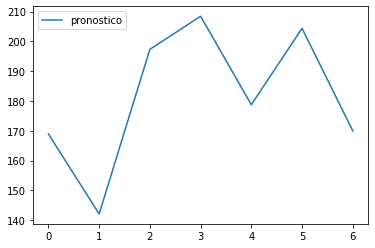

In [24]:
# PRONÓSTICO DE LOS SIGUIENTES 7 DÍAS (DEL 1 AL 7 DE DICIEMBRE)

prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico.csv')

In [25]:
prediccion1SemanaDiciembre

,pronostico
0,168.955295
1,142.133591
2,197.317350
3,208.426105
4,178.775576
5,204.367410
6,169.979366


A partir de los últimos 7 días de noviembre 2018 y utilizando nuestra red neuronal, hicimos el siguiente pronóstico de venta de unidades para la primer semana de diciembre.

# **SEGUNDA PARTE**

## Mejora del modelo de Series Temporales con **Múltiples Variables**

### https://www.aprendemachinelearning.com/pronostico-de-ventas-redes-neuronales-python-embeddings/

Para esta segunda parte se proponen 2 nuevos modelos con Redes Neuronales Feedforward para intentar mejorar los pronósticos de ventas:

* Un primer modelo tomando la fecha como nueva variable de entrada valiosa y que aporta datos.
* Un segundo modelo también usando la fecha como variable adicional, pero utilizándola con Embeddings.

Por lo tanto explicaremos lo qué son los embeddings utilizados en variables categóricas (se utiliza mucho en problemas de Procesamiento del Lenguaje Natural NLP para modelar).

Para estos modelos propuestos haremos la transformación a “problema de aprendizaje supervisado”. Para ello usaremos la misma función series_to_supervised() 

===> USAR FECHA COMO VARIABLE DE ENTRADA
* Usaremos el día como variable categórica con valores de 0 a 6 indicando día de semana y usaremos el número de mes como otra variable categórica. La “intuición” es que la red <<entenderá>> las estacionalidades dadas entre semana y mensuales.

===> EMBEDDINGS EN VARIABLES CATEGÓRICAS
* Utilizaremos embeddings en las variables categóricas, es decir, en la columna de día y de mes. Los valores de día van del 0 al 6 representando los días de la semana. Pero no quiere decir que el día 6 “vale” más que el día 0. Son identificadores. No tendría sentido decir que jueves es mayor que domingo. Sin embargo la red neuronal esto no lo sabe y podría interpretar erróneamente esos valores "categóricos"
  * Los ***embeddings*** son una manera de dar valoración útil- a datos categóricos. Para ello asignaremos una profundidad a cada “identificador”, es decir un vector con valores continuos inicialmente aleatorios. Esos valores se ajustarán con retropropagación al igual que nuestra red neuronal. Y finalmente nuestros datos categóricos quedan enriquecidos y dejan de ser “lunes” para ser unos vectores con valores que “significan algo”. 

**Dimensionalidad de los embeddings:**
Es bueno usar muchas dimensiones (profundidad) para modelar nuestras variables categóricas. Si tiene demasiadas, puede ocurrir overfitting. Entonces habrá que hacer prueba y error. Hay una regla que dice que hay que usar “una cuarta parte” del tamaño de la variable categórica (como máximo 2/4 partes): si tenemos 100 identificadores, usaremos como profundidad 25. 

**Conclusión de embeddings:**
Al asignarle vectores con valor numérico continuo a entradas categóricas, estos terminan funcionando como “una mini red neuronal” dentro de la red principal. Aprenden con backpropagation. Y resuelven como valores continuos esos identificadores discretos, acentuando su valor intrínseco.

In [26]:
url = "https://raw.githubusercontent.com/jbagnato/machine-learning/master/time_series.csv"
df = pd.read_csv(url, parse_dates=[0], header=None, index_col=0, names=['fecha','unidades'])

In [27]:
# CARGAR DATOS CATEGÓRICOS 

df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2017-01-02,236,0,1
2017-01-03,237,1,1
2017-01-04,290,2,1
2017-01-05,221,3,1
2017-01-07,128,5,1


In [28]:
# PROCESADO DE DATOS

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [29]:
PASOS=7

# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('unidades',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-11,0.0,1.0,-0.314815,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,...,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2,1,-0.433333
2017-01-12,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,...,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3,1,-0.607407
2017-01-13,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,...,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407,4,1,-0.522222
2017-01-14,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,...,-0.433333,3.0,1.0,-0.607407,4.0,1.0,-0.522222,5,1,-0.644444
2017-01-16,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,...,-0.607407,4.0,1.0,-0.522222,5.0,1.0,-0.644444,0,1,-0.344444


Ahora tenemos el triple de columnas porque hay más variables. <br>
Usaremos como entradas las columnas encabezadas como var1(t-7) a (t-1) y nuestra salida (lo que sería el valor “Y” de la función) será el var1(t) -la última columna-.



In [30]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)  # se eliminan las variables var1 y var2
print(newReframed.shape)
newReframed.head()

(597, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2017-01-11,0.0,1.0,-0.314815,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,...,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,-0.433333
2017-01-12,1.0,1.0,-0.311111,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,...,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,1.0,-0.433333,-0.607407
2017-01-13,2.0,1.0,-0.114815,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,...,1.0,1.0,-0.225926,2.0,1.0,-0.433333,3.0,1.0,-0.607407,-0.522222
2017-01-14,3.0,1.0,-0.370370,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,...,2.0,1.0,-0.433333,3.0,1.0,-0.607407,4.0,1.0,-0.522222,-0.644444
2017-01-16,5.0,1.0,-0.714815,0.0,1.0,-0.103704,1.0,1.0,-0.225926,2.0,...,3.0,1.0,-0.607407,4.0,1.0,-0.522222,5.0,1.0,-0.644444,-0.344444


In [31]:
# DIVIDIR EN TRAIN Y TEST

values = newReframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 21) (567,) (30, 1, 21) (30,)


### Creamos el Modelo de Red Neuronal
#### Como entradas son 21 columnas (7 pasos por 3 variables)

In [32]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh')) # se multiplica el número de pasos anteriores (7) por 3 (total de variables que se usa ahora)
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [33]:
# ENTRENAMIENTO

EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1, 7)              154       
                                                                 
 flatten_1 (Flatten)         (None, 7)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
81/81 [==============================] - 1s 4ms/step - loss: 0.6227 - mse: 0.6028 - val_loss: 0.2752 - val_mse: 0.1190
Epoch 2/40
81/81 [==============================] - 0s 2ms/step - loss: 0.3127 - mse: 0.1679 - val_loss: 0.1712 - val_mse: 0.0637
Epoch 3/40
81/81 [==============================] - 0s 2ms/s

Los resultados de esta red son levemente menores a la anterior. El modelo de serie temporal de 1 variable y este (múltiples variables) quedan prácticamente iguales. Es decir, que tras agregar las variables de fecha no pareciera haber mejoría en las métricas.

30


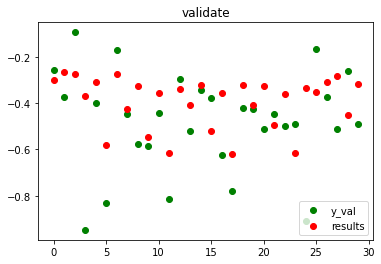

In [34]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g', label= 'y_val')
plt.scatter(range(len(results)),results,c='r', label= 'results')
plt.title('validate')
plt.legend(loc='lower right')
plt.show()

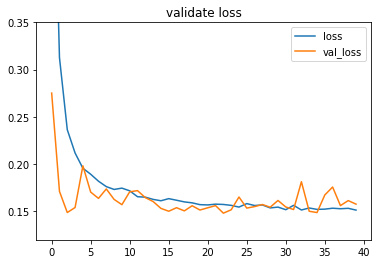

In [35]:
plt.ylim(0.12, 0.35)
plt.plot(history.history['loss'], label = 'loss')
plt.title('loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('validate loss')
plt.legend(loc='upper right')
plt.show()

En este modelo la curva de validación es algo errática. Las curvas del modelo 1 y 2 se mantienen sobre el 0.15.

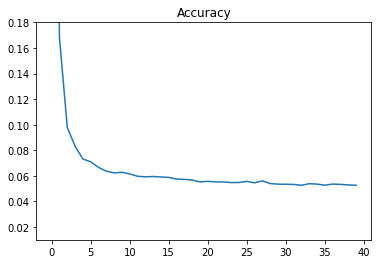

In [36]:
plt.ylim(0.01, 0.18)
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

Utilizamos la métrica de MSE, y vemos que, nuevamente, el modelo 1 y 2 se comportan de manera similar y se sitúan sobre el 0.06

In [37]:
# COMPARAR LOS DATOS REALES Y PREDICHOS

compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,252.000006,240.533047,11.466959
1,220.000002,249.164438,-29.164437
2,296.000009,247.733708,48.266301
3,64.999995,221.663473,-156.663478
4,212.999999,237.768934,-24.768935
5,95.999996,164.177877,-68.177881
6,274.999986,246.706661,28.293325
7,201.000000,206.253980,-5.253981
8,165.000001,233.219298,-68.219297
9,162.999996,173.919880,-10.919885


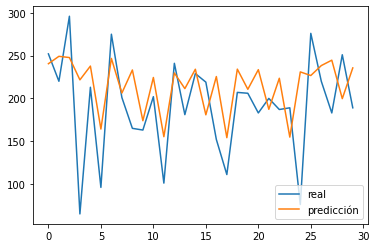

In [38]:
plt.plot(compara2['real'], label='real')
plt.plot(compara2['prediccion'], label='predicción')
plt.legend(loc='lower right')

Bastante similar al modelo 1 pero con algo más de amplitud.

### Pronóstico

A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [39]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

,unidades,weekday,month,scaled
fecha,,,,
2018-11-16,152,4,11,-0.625926
2018-11-17,111,5,11,-0.777778
2018-11-19,207,0,11,-0.422222
2018-11-20,206,1,11,-0.425926
2018-11-21,183,2,11,-0.511111
2018-11-22,200,3,11,-0.448148
2018-11-23,187,4,11,-0.496296
2018-11-24,189,5,11,-0.488889
2018-11-25,76,6,11,-0.907407


In [40]:
# PREPARAMOS LOS DATOS PARA TEST 

scaledMerge=ultimosDias.drop('unidades',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head(7)

[[ 4.         11.         -0.62592596]
 [ 5.         11.         -0.77777779]
 [ 0.         11.         -0.42222226]
 [ 1.         11.         -0.42592597]
 [ 2.         11.         -0.51111114]
 [ 3.         11.         -0.44814819]
 [ 4.         11.         -0.49629635]
 [ 5.         11.         -0.48888892]
 [ 6.         11.         -0.9074074 ]
 [ 0.         11.         -0.16666675]
 [ 1.         11.         -0.3740741 ]
 [ 2.         11.         -0.51111114]
 [ 3.         11.         -0.25925928]
 [ 4.         11.         -0.48888892]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,
2018-11-24,4.0,11.0,-0.625926,5.0,11.0,-0.777778,0.0,11.0,-0.422222,1.0,...,-0.425926,2.0,11.0,-0.511111,3.0,11.0,-0.448148,4.0,11.0,-0.496296
2018-11-25,5.0,11.0,-0.777778,0.0,11.0,-0.422222,1.0,11.0,-0.425926,2.0,...,-0.511111,3.0,11.0,-0.448148,4.0,11.0,-0.496296,5.0,11.0,-0.488889
2018-11-26,0.0,11.0,-0.422222,1.0,11.0,-0.425926,2.0,11.0,-0.511111,3.0,...,-0.448148,4.0,11.0,-0.496296,5.0,11.0,-0.488889,6.0,11.0,-0.907407
2018-11-27,1.0,11.0,-0.425926,2.0,11.0,-0.511111,3.0,11.0,-0.448148,4.0,...,-0.496296,5.0,11.0,-0.488889,6.0,11.0,-0.907407,0.0,11.0,-0.166667
2018-11-28,2.0,11.0,-0.511111,3.0,11.0,-0.448148,4.0,11.0,-0.496296,5.0,...,-0.488889,6.0,11.0,-0.907407,0.0,11.0,-0.166667,1.0,11.0,-0.374074
2018-11-29,3.0,11.0,-0.448148,4.0,11.0,-0.496296,5.0,11.0,-0.488889,6.0,...,-0.907407,0.0,11.0,-0.166667,1.0,11.0,-0.374074,2.0,11.0,-0.511111
2018-11-30,4.0,11.0,-0.496296,5.0,11.0,-0.488889,6.0,11.0,-0.907407,0.0,...,-0.166667,1.0,11.0,-0.374074,2.0,11.0,-0.511111,3.0,11.0,-0.259259


In [41]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()

(1, 1, 21)
[[[ 4.         11.         -0.49629635  5.         11.
   -0.48888892  6.         11.         -0.9074074   0.
   11.         -0.16666675  1.         11.         -0.3740741
    2.         11.         -0.51111114  3.         11.
   -0.25925928]]]


In [42]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [43]:
# PRONÓSTICO PARA LA PRÓXIMA SEMANA

results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 4.         11.         -0.49629635  5.         11.
   -0.48888892  6.         11.         -0.9074074   0.
   11.         -0.16666675  1.         11.         -0.3740741
    2.         11.         -0.51111114  3.         11.
   -0.25925928]]]
pred 1 [[[ 5.         11.         -0.48888892  6.         11.
   -0.9074074   0.         11.         -0.16666675  1.
   11.         -0.3740741   2.         11.         -0.51111114
    3.         11.         -0.25925928  5.         12.
   -0.316232  ]]]
pred 2 [[[ 6.         11.         -0.9074074   0.         11.
   -0.16666675  1.         11.         -0.3740741   2.
   11.         -0.51111114  3.         11.         -0.25925928
    5.         12.         -0.316232    6.         12.
   -0.56821907]]]
pred 3 [[[ 0.         11.         -0.16666675  1.         11.
   -0.3740741   2.         11.         -0.51111114  3.
   11.         -0.25925928  5.         12.         -0.316232
    6.         12.         -0.56821907  0.         12.
   -0.294

In [44]:
# RECONVERTIMOS LOS RESULTADOS

adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.316232], dtype=float32), array([-0.56821907], dtype=float32), array([-0.29444587], dtype=float32), array([-0.33213353], dtype=float32), array([-0.30377275], dtype=float32), array([-0.46790385], dtype=float32), array([-0.33593607], dtype=float32)]


array([[235.6173703 ],
       [167.58086024],
       [241.49962376],
       [231.32395558],
       [238.98136741],
       [194.66596829],
       [230.29727032]])

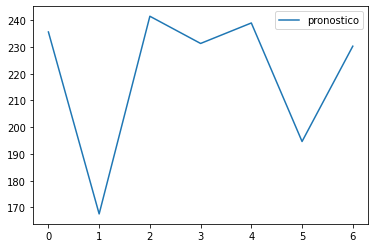

In [45]:
# VISUALIZAR PRONÓSTICO

prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico_multivariate.csv')

In [46]:
prediccion1SemanaDiciembre

,pronostico
0,235.617370
1,167.580860
2,241.499624
3,231.323956
4,238.981367
5,194.665968
6,230.297270


## Mejora del modelo de Series Temporales con **EMBEDDINGS**

In [47]:
# NUEVAS LIBRERÍAS

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model


In [48]:
url = "https://raw.githubusercontent.com/jbagnato/machine-learning/master/time_series.csv"
df = pd.read_csv(url, parse_dates=[0], header=None, index_col=0, names=['fecha','unidades'])

df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,unidades,weekday,month
fecha,,,
2017-01-02,236,0,1
2017-01-03,237,1,1
2017-01-04,290,2,1
2017-01-05,221,3,1
2017-01-07,128,5,1


In [49]:
# PROCESADO DE LOS DATOS

PASOS=7
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:
# load dataset
values = df['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df['weekday']
reframed['month']=df['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df['weekday'][i+8]
    reframed['month'].loc[contador]=df['month'][i+8]
    contador=contador+1
reframed.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month
0,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,3.0,1.0
1,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,4.0,1.0
2,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,5.0,1.0
3,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,0.0,1.0
4,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444,1.0,1.0


In [51]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,3.0,1.0,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
1,4.0,1.0,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
2,5.0,1.0,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
3,0.0,1.0,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
4,1.0,1.0,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444
...,...,...,...,...,...,...,...,...,...,...
591,0.0,11.0,-0.777778,-0.422222,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407
592,1.0,11.0,-0.422222,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667
593,2.0,11.0,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667,-0.374074
594,3.0,11.0,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667,-0.374074,-0.511111


In [52]:
# DIVIDIR EN TRAIN Y TEST

training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[595-30:595]
valid_target=target_data[595-30:595]

training_data = training_data[0:595]
target_data=target_data[0:595]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(595, 9) (595,) (30, 9) (30,)


### Creamos el Modelo de Red Neuronal
#### Utilizaremos una Red Feedforward con Embeddings
Tenemos como entradas 9 columnas (2 embeddings y 7 pasos)

In [53]:
def crear_modeloEmbeddings():
    emb_dias = 2 #tamaño profundidad de embeddings
    emb_meses = 4

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

In [54]:
#ENTRENAMIENTO 

EPOCHS=40

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dias (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 meses (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 2)         16          ['dias[0][0]']                   
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 4)         52          ['meses[0][0]']                  
                                                                                              

El modelo con embeddings sí que logra una mejora algo más evidente: el validation_loss pasa de 0.15 a 0.10 y el validation_MSE de 0.05 a 0.02.

30


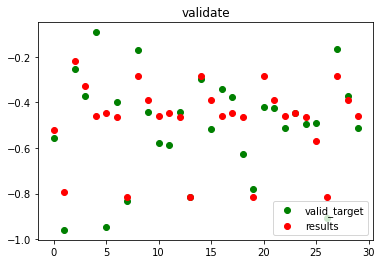

In [55]:
# VISUALIZAMOS

results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g', label='valid_target')
plt.scatter(range(len(results)),results,c='r', label='results')
plt.title('validate')
plt.legend(loc='lower right')
plt.show()

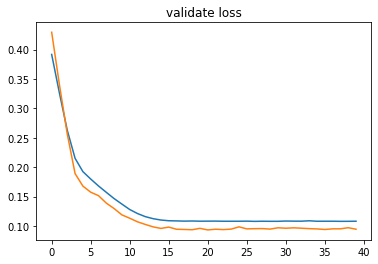

In [56]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

Las curvas del modelo 1 y 2 se mantienen sobre el 0.15 y 0.16 mientras que la del 3er modelo desciende algo más en torno del 0.10

In [59]:
# COMPARAR VALOR REAL Y PREDICHO

compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(12)

,real,prediccion,diferencia
0,171.000000,180.617081,-9.617081
1,62.000004,106.994766,-44.994762
2,252.000000,262.226349,-10.226349
3,220.000000,232.402679,-12.402679
4,296.000000,196.749115,99.250885
5,64.999992,200.857498,-135.857513
6,213.000000,195.843445,17.156555
7,95.999992,100.975174,-4.975182
8,275.000000,243.916153,31.083847
9,201.000000,215.522278,-14.522278


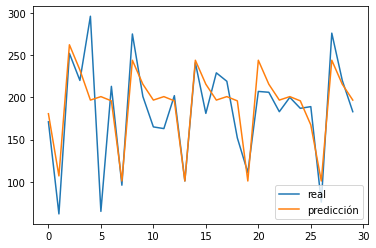

In [60]:
plt.plot(compara2['real'], label='real')
plt.plot(compara2['prediccion'], label='predicción')
plt.legend(loc='lower right')

Como se observa, a diferencia de los modelos anteriores, los embeddings proveen mayor flexibilidad a la curva de pronóstico y aciertos, permitiendo así un mejor ajuste lo de los valores predichos a los reales. 

### Pronóstico
A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [61]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

,unidades,weekday,month
fecha,,,
2018-11-16,152,4,11
2018-11-17,111,5,11
2018-11-19,207,0,11
2018-11-20,206,1,11
2018-11-21,183,2,11
2018-11-22,200,3,11
2018-11-23,187,4,11
2018-11-24,189,5,11
2018-11-25,76,6,11


In [62]:
# PREPARAMOS DATOS PARA TEST

# load dataset
values = ultimosDias['unidades'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=ultimosDias['weekday']
reframed['month']=ultimosDias['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=ultimosDias['weekday'][i+8]
    reframed['month'].loc[contador]=ultimosDias['month'][i+8]
    contador=contador+1
reframed.head()

reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)'] ]
reordenado.dropna(inplace=True)
reordenado

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
0,6.0,11.0,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
1,0.0,11.0,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
2,1.0,11.0,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
3,2.0,11.0,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
4,3.0,11.0,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
5,4.0,11.0,0.24,0.11,0.13,-1.00,1.00,0.44,0.07


In [63]:
values = reordenado.values
x_test = values[5:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = reordenado.weekday[len(reordenado.index)-1]
ultDiaSemana

(1, 1, 9)
[[[ 4.         11.          0.24000001  0.11000001  0.13
   -1.          1.          0.44000006  0.06999993]]]


4.0

In [64]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i+2] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][0]=ultDiaSemana
    x_test[0][0][1]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [65]:
# PRONÓSTICO PARA LA PRÓXIMA SEMANA

results=[]
for i in range(7):
    dia=np.array([x_test[0][0][0]])
    mes=np.array([x_test[0][0][1]])
    valores=np.array([x_test[0][0][2:9]])
    parcial=model.predict([dia, mes, valores])
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 4.         11.          0.24000001  0.11000001  0.13
   -1.          1.          0.44000006  0.06999993]]]
pred 1 [[[ 5.         12.          0.11000001  0.13       -1.
    1.          0.44000006  0.06999993 -0.44497225]]]
pred 2 [[[ 6.         12.          0.13       -1.          1.
    0.44000006  0.06999993 -0.44497225 -0.34500852]]]
pred 3 [[[ 0.         12.         -1.          1.          0.44000006
    0.06999993 -0.44497225 -0.34500852 -0.46726495]]]
pred 4 [[[ 1.         12.          1.          0.44000006  0.06999993
   -0.44497225 -0.34500852 -0.46726495 -0.76749653]]]
pred 5 [[[ 2.         12.          0.44000006  0.06999993 -0.44497225
   -0.34500852 -0.46726495 -0.76749653 -0.14857055]]]
pred 6 [[[ 3.         12.          0.06999993 -0.44497225 -0.34500852
   -0.46726495 -0.76749653 -0.14857055 -0.26323351]]]


In [66]:
# RECONVERTIR RESULTADOS

adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.44497225], dtype=float32), array([-0.34500852], dtype=float32), array([-0.46726495], dtype=float32), array([-0.7674965], dtype=float32), array([-0.14857055], dtype=float32), array([-0.2632335], dtype=float32), array([-0.34140462], dtype=float32)]


array([[131.5027773 ],
       [141.49914998],
       [129.27350691],
       [ 99.25034864],
       [161.1429474 ],
       [149.67665113],
       [141.85954053]])

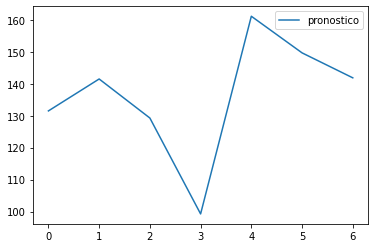

In [67]:
# VISUALIZAR

prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico_embeddings.csv')

In [68]:
prediccion1SemanaDiciembre

,pronostico
0,131.502777
1,141.499150
2,129.273507
3,99.250349
4,161.142947
5,149.676651
6,141.859541


## CONCLUSIONES

* Como primera conclusión, podemos decir que **mejoran las predicciones al agregar más variables de entrada a la red**. Realmente notamos mejoría con nuestro modelo 3 al usar Embeddings en la red neuronal.

* Uno de los pasos más importantes, al realizar el pre procesado, consiste en **convertir nuestra serie en un modelo de aprendizaje supervisado**.


La *PARTE 2* será un intento de mejorar el modelo a partir de las indicaciones realizadas por el autor, que son las siguientes: 
* Variar la cantidad de EPOCHS
* Probar otro optimizador distinto a Adam, ó configurar valores distintos de Learning Rate.
* Cambiar la arquitectura de la Red Neuronal:
   - Cambiar la cantidad de Neuronas de la capa oculta.
   - Agregar más capas ocultas
   - Probar utilizando más de 7 días previos para predecir. O probar con menos días.
    * Se puede probar de intentar predecir más de 1 día por vez (sin iterar el resultado se hizo con la función agregarNuevoValor() )